In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from nltk.corpus import stopwords
import re,string,unicodedata
from string import punctuation 
from bs4 import BeautifulSoup

import math
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from typing import Dict, List

In [2]:
# Turns out the Kaggle dataset is heavily biased, a one word predictor can get 99% accuracy..
#TRUE_PATH = "kaggle_fakenews/True.csv"
#FAKE_PATH = "kaggle_fakenews/Fake.csv"

TRAIN_PATH = "liar_dataset/train.tsv"
VAL_PATH = "liar_dataset/valid.tsv"
TEST_PATH = "liar_dataset/test.tsv"

In [3]:
column_names = ["statement_json", "label", "statement", "subject", "speaker", "speaker_title", "state_info", "party_affiliation", "barely_true_count", "false_count", "half_true_count", "mostly_true_count", "pants_fire_count", "context", "justification"]

train_df = pd.read_csv(TRAIN_PATH, sep="\t", names=column_names)
val_df = pd.read_csv(VAL_PATH, sep="\t", names=column_names)
test_df = pd.read_csv(TEST_PATH, sep="\t", names=column_names)

In [5]:
train_df.head()

,statement_json,label,statement,subject,speaker,speaker_title,state_info,party_affiliation,barely_true_count,false_count,half_true_count,mostly_true_count,pants_fire_count,context,justification
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,NaN
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,NaN
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,NaN
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,NaN
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,NaN


In [12]:
val_df.head()

,statement_json,label,statement,subject,speaker,speaker_title,state_info,party_affiliation,barely_true_count,false_count,half_true_count,mostly_true_count,pants_fire_count,context,justification
0,12134.json,barely-true,We have less Americans working now than in the...,"economy,jobs",vicky-hartzler,U.S. Representative,Missouri,republican,1,0,1,0,0,an interview with ABC17 News,NaN
1,238.json,pants-fire,"When Obama was sworn into office, he DID NOT u...","obama-birth-certificate,religion",chain-email,NaN,NaN,none,11,43,8,5,105,NaN,NaN
2,7891.json,false,Says Having organizations parading as being so...,"campaign-finance,congress,taxes",earl-blumenauer,U.S. representative,Oregon,democrat,0,1,1,1,0,a U.S. Ways and Means hearing,NaN
3,8169.json,half-true,Says nearly half of Oregons children are poor.,poverty,jim-francesconi,Member of the State Board of Higher Education,Oregon,none,0,1,1,1,0,an opinion article,NaN
4,929.json,half-true,On attacks by Republicans that various program...,"economy,stimulus",barack-obama,President,Illinois,democrat,70,71,160,163,9,interview with CBS News,NaN


In [13]:
test_df.head()

,statement_json,label,statement,subject,speaker,speaker_title,state_info,party_affiliation,barely_true_count,false_count,half_true_count,mostly_true_count,pants_fire_count,context,justification
0,11972.json,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview,NaN
1,11685.json,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference,NaN
2,11096.json,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.,NaN
3,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show,NaN
4,9524.json,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,2,2,7,a web video,NaN


# Basic dataset statistics

In [17]:
len(train_df)

10240

In [18]:
len(val_df)

1284

In [19]:
len(test_df)

1267

Checking for NaN values

In [9]:
train_df.isna().sum()

statement_json           0
label                    0
statement                0
subject                  2
speaker                  2
speaker_title         2897
state_info            2208
party_affiliation        2
barely_true_count        2
false_count              2
half_true_count          2
mostly_true_count        2
pants_fire_count         2
context                102
justification        10240
dtype: int64

Justification column is almost all NaN 

In [16]:
train_df.speaker_title.count()

7343

In [21]:
train_df.speaker_title.nunique()

1184

In [63]:
train_df.context.nunique()

4345

In [64]:
train_df.context.value_counts(normalize=True)

a news release             0.023772
an interview               0.022588
a press release            0.021996
a speech                   0.021109
a TV ad                    0.017755
                             ...   
a guest commentary         0.000099
radio and television ad    0.000099
a campaign brochure.       0.000099
news report                0.000099
her column.                0.000099
Name: context, Length: 4345, dtype: float64

In [65]:
train_df.context.isna().sum()

102

Look at distribution of the labels

In [22]:
train_df.label.value_counts(normalize=True)

half-true      0.206445
false          0.194824
mostly-true    0.191602
true           0.163672
barely-true    0.161523
pants-fire     0.081934
Name: label, dtype: float64

The distribution of labels is roughly equal except for pants-fire which is much lower

<AxesSubplot:xlabel='label', ylabel='count'>

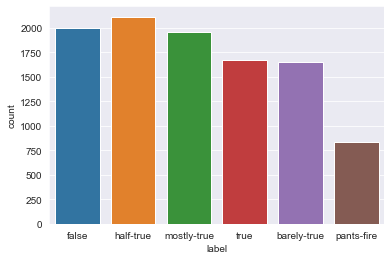

In [25]:
sns.set_style("darkgrid")
sns.countplot(x=train_df.label)

Now looking at distribution of subjects

In [27]:
train_df.subject.nunique()

3827

In [29]:
train_df.subject.value_counts().nlargest(10)

health-care             381
taxes                   308
immigration             253
elections               252
education               237
candidates-biography    190
economy                 137
guns                    130
economy,jobs            125
federal-budget          121
Name: subject, dtype: int64

Plotting counts per subject

In [31]:
subject_counts = train_df.subject.value_counts().nlargest(10)
px.bar(subject_counts, x=subject_counts.index, y=subject_counts.values, labels={"index": "subject", "y": "counts"}, title="Counts Per Subject (Top 10)")

[Text(0, 0, 'health-care'),
 Text(1, 0, 'taxes'),
 Text(2, 0, 'immigration'),
 Text(3, 0, 'elections'),
 Text(4, 0, 'education')]

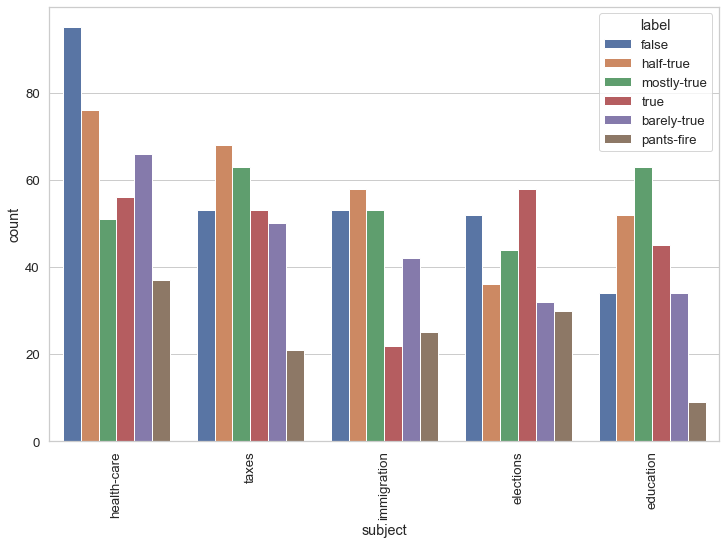

In [33]:
plt.figure(figsize = (12,8))
sns.set(style = "whitegrid",font_scale = 1.2)
chart = sns.countplot(x = "subject", hue = "label" , data = train_df, order=train_df.subject.value_counts().nlargest(5).index) # hue determines color
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

Look at distribution of party affiliation

In [34]:
affiliation_counts = train_df.party_affiliation.value_counts()
px.bar(affiliation_counts, x=affiliation_counts.index, y=affiliation_counts.values, labels={"index": "affiliation", "y": "counts"}, title="Counts Per Affiliation")

We see there are slightly more Republican-affiliated statements than Democratic ones, with a long tail of other affiliations.

# Binarize the labels to True or False

This will make the classification algorithms more efficient for now, later can try with all of the classification labels included. 

In [10]:
# Convert from 6-way scale to binary scale
def get_binary_label(label: str) -> bool:
    if label in {"pants-fire", "barely-true", "false"}:
        return False
    elif label in {"true", "half-true", "mostly-true"}:
        return True

In [11]:
train_df["binary_label"] = train_df.label.apply(get_binary_label)

In [12]:
train_df.head()

,statement_json,label,statement,subject,speaker,speaker_title,state_info,party_affiliation,barely_true_count,false_count,half_true_count,mostly_true_count,pants_fire_count,context,justification,binary_label
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,NaN,False
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,NaN,True
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,NaN,True
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,NaN,False
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,NaN,True


Look at the binary label outcomes for the various party affiliations:

In [38]:
party_groups = train_df.groupby(["party_affiliation"])

In [39]:
party_groups.get_group("republican").binary_label.value_counts(normalize=True)

True     0.50189
False    0.49811
Name: binary_label, dtype: float64

In [40]:
party_groups.get_group("democrat").binary_label.value_counts(normalize=True)

True     0.66217
False    0.33783
Name: binary_label, dtype: float64

We see that *in this dataset* the Republican party group has roughly equal number of True and False statements, while the Democrat statements are often more True and False.

In [41]:
train_df.binary_label.value_counts(normalize=True)

True     0.561719
False    0.438281
Name: binary_label, dtype: float64

There is some bias in this dataset towards True labels

Grab an example text for viewing:

In [46]:
train_df.iloc[1,2]

'When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.'

*WHAT ARE STOPWORDS?*

Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. For example, the words like the, he, have etc. Such words are already captured this in corpus named corpus. We can download these stop words now:

In [14]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

## Data Cleaning

Beautiful Soup is a Python library for pulling data out of HTML and XML files. the string.split() method splits a string into a list.

In [15]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)

#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

#Removing the noisy text (use all the above functions)
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

#Apply function on text column
train_df['statement']=train_df['statement'].apply(denoise_text)

In [16]:
# Split into True and False statements to do analysis on them seperately
true_ex = train_df[train_df['binary_label'] == True]
false_ex = train_df[train_df['binary_label'] == False]

In [17]:
# view the true and false data to get a feel for it
true_ex.sample(frac=0.2).head(25)

,statement_json,label,statement,subject,speaker,speaker_title,state_info,party_affiliation,barely_true_count,false_count,half_true_count,mostly_true_count,pants_fire_count,context,justification,binary_label
7207,5474.json,half-true,"2011, 28,000 new Tennessee jobs created $4 bil...","economy,jobs",bill-haslam,Governor,Tennessee,republican,0.0,1.0,1.0,0.0,0.0,his State of the State address.,NaN,True
2313,12807.json,mostly-true,Illegal immigration crime rate low theyve deca...,"crime,history,immigration",barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,a speech at the Democratic National Convention,NaN,True
2229,665.json,half-true,"(McCain) says ""we can't ... timelines draw tro...",iraq,joe-biden,U.S. senator,Delaware,democrat,11.0,10.0,21.0,16.0,4.0,Denver,NaN,True
9384,11585.json,mostly-true,United States (is) largest provider humanitari...,"foreign-policy,terrorism",barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,a joint statement with the president of Turkey.,NaN,True
6269,7576.json,half-true,men outlive fertility.,"children,families,gays-and-lesbians,human-righ...",charles-cooper,NaN,NaN,newsmaker,0.0,0.0,1.0,0.0,0.0,arguments before the U.S. Supreme Court,NaN,True
8115,2575.json,half-true,Houston suffered $1.7 billion operating losses...,"economy,government-efficiency,message-machine,...",rick-perry,Governor,Texas,republican,30.0,30.0,42.0,23.0,18.0,a television ad,NaN,True
3841,1678.json,true,President Obama attempted filibuster Justice A...,"supreme-court,abc-news-week",jon-kyl,U.S. Senator,Arizona,republican,0.0,2.0,4.0,3.0,0.0,"in an interview on ABC News' ""This Week""",NaN,True
9782,4360.json,half-true,Says potential GOP U.S. Senate candidate Tommy...,"bipartisanship,health-care,public-health",club-growth,NaN,NaN,none,4.0,5.0,4.0,2.0,0.0,a TV ad,NaN,True
2719,11029.json,true,Greece big economy. size metropolitan Miami.,"economy,foreign-policy",paul-krugman,New York Times columnist,NaN,none,0.0,2.0,3.0,4.0,0.0,"an interview on ABC's ""This Week with George S...",NaN,True
844,10310.json,mostly-true,Bill Howell consistent force behind every majo...,"taxes,voting-record",susan-stimpson,NaN,Virginia,republican,0.0,1.0,0.0,1.0,0.0,a news release.,NaN,True


In [85]:
false_ex.sample(frac=0.2).head(25)

,statement_json,label,statement,subject,speaker,speaker_title,state_info,party_affiliation,barely_true_count,false_count,half_true_count,mostly_true_count,pants_fire_count,context,justification,binary_label
8143,4324.json,false,Says Texas schools massive increases class siz...,education,arne-duncan,U.S. Secretary of Education,Illinois,democrat,1.0,2.0,1.0,2.0,0.0,an interview.,NaN,False
5321,5257.json,false,Romneycare sent costs spiraling control Massac...,"health-care,message-machine-2012",winning-our-future,NaN,NaN,none,2.0,2.0,3.0,1.0,0.0,a television ad,NaN,False
1854,10296.json,false,pass rate high school level test join military...,"education,military",jeb-bush,NaN,Florida,republican,17.0,5.0,17.0,24.0,2.0,a Wall Street Journal CEO Council event,NaN,False
5865,8233.json,barely-true,highest general revenue state history next yea...,"economy,taxes",rick-scott,Governor,Florida,republican,28.0,23.0,38.0,34.0,7.0,a speech at the Americans for Prosperity Found...,NaN,False
1993,1297.json,pants-fire,"Page 92 House health care bill ""says specifica...",health-care,michele-bachmann,Congresswoman,Minnesota,republican,8.0,22.0,6.0,4.0,16.0,an interview on Sean Hannity's show on the Fox...,NaN,False
3385,2517.json,false,Social Security Ponzi scheme.,social-security,john-loughlin,"owner, Media-Rite LLC",Rhode Island,republican,1.0,2.0,0.0,0.0,1.0,a meet-the-candidates forum,NaN,False
3398,829.json,pants-fire,Michelle Obama ordered $400 worth lobster cavi...,candidates-biography,chain-email,NaN,NaN,none,11.0,43.0,8.0,5.0,105.0,a chain e-mail,NaN,False
1697,3961.json,false,Says Allen West violatedfederal law scuba divi...,"legal-issues,patriotism",blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a blog,NaN,False
379,9853.json,false,"black America country, itd 15th wealthiest nat...","corrections-and-updates,economy,poverty",larry-elder,Radio talk show host,NaN,talk-show-host,1.0,3.0,0.0,0.0,0.0,comments on CNN,NaN,False
2685,12406.json,pants-fire,Says Jacky Rosen refused tell us whether suppo...,elections,national-republican-congressional-committee,NaN,NaN,republican,18.0,9.0,8.0,5.0,8.0,an automated call,NaN,False


In [18]:
# we can see there are 72 different state values, which means some are written in various forms
true_ex.state_info.value_counts()

Florida                                              597
Texas                                                542
Illinois                                             397
Wisconsin                                            363
New York                                             327
                                                    ... 
Atlanta                                                1
Virginia director, Coalition to Stop Gun Violence      1
Rhode Island                                           1
Virginia                                               1
PA - Pennsylvania                                      1
Name: state_info, Length: 72, dtype: int64

In [20]:
# still have a lot of na vlaues in state_info
train_df['state_info'].isna().sum()

2208

In [21]:
# Clean up the state_info column
stripped = false_ex.state_info.copy().str.strip()
false_ex.loc[:, "state_info"] = stripped

stripped = true_ex.state_info.copy().str.strip()
true_ex.loc[:, "state_info"] = stripped

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [26]:
# Clean up the variants of the state_info, making sure spelling errors etc. classified correctly
CANONICAL_TO_VARIANTS = {
    "Tennessee": {"Tennessee", "Tennesse"},
    "Washington D.C.": {"District of Columbia", "Washington D.C.", "Washington, D.C.", "Washington DC"},
    "Texas": {"Tex", "Texas"}, 
    "Washington": {"Washington", "Washington state"},
    "Virginia": {"Virginia", "Virgina", "Virgiia"},
    "Pennsylvania": {"Pennsylvania", "PA - Pennsylvania"},
    "Rhode Island": {"Rhode Island", "Rhode island"},
    "Ohio": {"Ohio", "ohio"}
}
# will pass this dictionary into the following function which loops through all of the variants and sets them equal to the canonical

def get_variant_to_canonical(can_to_var: Dict):
    variant_to_canonical = {}
    for canonical, variant in can_to_var.items():
        for var in variant:
            variant_to_canonical[var] = canonical
    return variant_to_canonical

variant_to_canonical = get_variant_to_canonical(CANONICAL_TO_VARIANTS)

In [27]:
def clean_variant(state_info, variant_to_canonical):
    if state_info in variant_to_canonical.keys():
        return variant_to_canonical[state_info]
    return state_info

true_ex.loc[:, "state_info"] = true_ex.state_info.apply(lambda x: clean_variant(x, variant_to_canonical))
false_ex.loc[:, "state_info"] = false_ex.state_info.apply(lambda x: clean_variant(x, variant_to_canonical))

Looking at the same text example as before, we can see the changes were successfully implemented

In [28]:
true_ex.state_info.value_counts()

Florida                                              601
Texas                                                542
Illinois                                             398
Wisconsin                                            364
New York                                             328
Ohio                                                 302
Georgia                                              274
Virginia                                             229
Rhode Island                                         217
Oregon                                               151
New Jersey                                           150
Massachusetts                                        128
Arizona                                              107
California                                           102
Washington D.C.                                       80
Vermont                                               69
Arkansas                                              52
New Hampshire                  

In [32]:
none_stuff = true_ex['state_info'].isna().sum()
none_stuff

1089

In [33]:
def clean_na(state_info):
    if not state_info:
        return "none"
    return state_info

In [34]:
true_ex.loc[:, "state_info"] = true_ex.state_info.apply(lambda x: clean_na(x))

In [48]:
none_stuff = true_ex[true_ex['speaker_title'].isnull()]
none_stuff.head() # found some NaN vlaues. Want to see what type they are of.

,statement_json,label,statement,subject,speaker,speaker_title,state_info,party_affiliation,barely_true_count,false_count,half_true_count,mostly_true_count,pants_fire_count,context,justification,binary_label
4,9028.json,half-true,economic turnaround started end term.,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,NaN,True
8,5602.json,half-true,"However, took $19.5 million Oregon Lottery fun...",jobs,oregon-lottery,NaN,NaN,organization,0.0,0.0,1.0,0.0,1.0,a website,NaN,True
13,8616.json,mostly-true,economy bled $24 billion due government shutdown.,"economy,federal-budget,health-care",doonesbury,NaN,NaN,none,0.0,0.0,2.0,4.0,0.0,a Doonesbury strip in the Sunday comics,NaN,True
23,2673.json,half-true,"Says Scott Walker favors cutting 350,000 famil...","health-care,message-machine",greater-wisconsin-political-fund,NaN,Wisconsin,none,3.0,3.0,3.0,1.0,1.0,a campaign TV ad,NaN,True
37,1038.json,true,"nuclear test conducted nation time Earth's 2,0...",military,north-korea,NaN,NaN,none,0.0,0.0,0.0,0.0,0.0,a released statement,NaN,True


In [55]:
one_example = true_ex['speaker_title'][4]
print(type(one_example))
print(one_example)

<class 'float'>
nan


In [ ]:
# already imported math

In [62]:
if math.isnan(one_example):
    print('yes')

yes


In [44]:
true_ex['state_info'].replace(np.nan, "Unknown")

1         Virginia
2         Illinois
4          Florida
5        Wisconsin
7         Illinois
           ...    
10232      Unknown
10234      Unknown
10235      Florida
10236      Georgia
10237      Georgia
Name: state_info, Length: 5752, dtype: object

In [98]:
# there are 52 unique values now, with the two extra being "unknown" and "Virginia director, Coalition to Stop Gun Violence"
true_ex.state_info.nunique()

52

In [100]:
false_ex.state_info.nunique()

55

In [101]:
# false df has some state_info entries which are countries:
# the United States, China, Russia, United Kingdom, Qatar, and None
false_ex.state_info.value_counts()

Texas                468
Florida              402
Wisconsin            350
New York             331
Virginia             183
Illinois             160
Georgia              159
Rhode Island         154
Ohio                 146
Oregon                91
New Jersey            91
Massachusetts         84
Arizona               75
Washington D.C.       67
California            61
Pennsylvania          49
Minnesota             40
Tennessee             39
New Hampshire         38
Alaska                35
Arkansas              32
Kentucky              31
Vermont               29
Nevada                25
Delaware              25
Maryland              23
Indiana               21
North Carolina        17
South Carolina        17
Missouri              15
Colorado              15
Iowa                  12
Louisiana             11
New Mexico             9
Michigan               9
Alabama                8
Kansas                 7
Utah                   6
Connecticut            6
Oklahoma               5


In [102]:
print(true_ex[true_ex['state_info']=='Virginia director, Coalition to Stop Gun Violence'].index.values)

[5766]


In [106]:
print(false_ex[false_ex['state_info']=='the United States'].index.values)
print(false_ex[false_ex['state_info']=='United Kingdom'].index.values)
print(false_ex[false_ex['state_info']=='China'].index.values)
print(false_ex[false_ex['state_info']=='Russia'].index.values)
print(false_ex[false_ex['state_info']=='Qatar'].index.values)

[9774]
[3248]
[3018]
[1546]
[4354]


## See how much the state_info could be useful feature

In [107]:
state_true_counts = true_ex.state_info.value_counts()
px.bar(state_true_counts, x=state_true_counts.index, y=state_true_counts.values, labels={"index": "state", "y": "counts"}, title="True Statement State Distribution")

In [108]:
state_false_counts = false_ex.state_info.value_counts()
px.bar(state_false_counts, x=state_false_counts.index, y=state_false_counts.values, labels={"index": "state", "y": "counts"}, title="False Statement State Distribution")

They are mostly the same for the top few states, so there does not seem to be a state which is significantly more inclines to have True or False statements

# Exploratory Data Analysis - Ngram Analysis

For starters, it’s always helpful to compute ngram measures such as the most frequently seen unigram and bigrams in the data.

In [109]:
unigram_lens = train_df.statement.str.split().str.len()

In [110]:
px.histogram(unigram_lens, x=unigram_lens.values, labels={"x": "unigram lens"}, title="Unigram Length Distribution")

In [111]:
unigram_lens.median()

10.0

In [112]:
unigram_lens.mean()

11.270241234495556

In [113]:
unigram_lens.max()

347

Use CountVectorizer to convert a collection of text documents to a matrix of token counts. This implementation produces a sparse representation of the counts using scipy.sparse.csr_matrix. Defining this function get_top_ngrams() is common practice:

In [114]:
def get_top_ngrams(corpus, ngram_len: int=1, num: int=None) -> List:
    vec = CountVectorizer(ngram_range=(ngram_len, ngram_len), stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:num]

### True Unigrams

In [132]:
top_unigrams_true = get_top_ngrams(true_ex.statement, 1, 30)
top_unigrams_true

[('says', 1217),
 ('percent', 839),
 ('state', 513),
 ('000', 466),
 ('year', 398),
 ('tax', 386),
 ('years', 381),
 ('states', 359),
 ('million', 357),
 ('obama', 338),
 ('people', 336),
 ('health', 305),
 ('president', 291),
 ('jobs', 289),
 ('new', 268),
 ('texas', 244),
 ('care', 234),
 ('taxes', 229),
 ('billion', 224),
 ('country', 224),
 ('federal', 208),
 ('united', 202),
 ('said', 194),
 ('budget', 190),
 ('rate', 186),
 ('pay', 177),
 ('voted', 177),
 ('10', 176),
 ('time', 172),
 ('government', 165)]

In [133]:
true_state_distr = pd.DataFrame(top_unigrams_true, columns=["unigram", "count"])

In [135]:
px.bar(true_state_distr, x="unigram", y="count", title="Top True Unigrams Frequency")

### False Unigrams

In [136]:
top_unigrams_false = get_top_ngrams(false_ex[false_ex.statement.notnull()].statement.str.lower(), num=30)
false_state_distr = pd.DataFrame(top_unigrams_false, columns=["unigram", "count"])
px.bar(false_state_distr, x="unigram", y="count", title="Top False Unigrams Frequency")

The top used words are fairly similar between the false and true texts

### True Bigrams

In [137]:
top_bigrams_true = get_top_ngrams(true_ex[true_ex.statement.notnull()].statement.str.lower(), ngram_len=2, num=30)
true_state_distr = pd.DataFrame(top_bigrams_true, columns=["bigram", "count"])
px.bar(true_state_distr, x="bigram", y="count", title="Top True Bigrams Frequency")

### False Bigrams

In [138]:
top_bigrams_false = get_top_ngrams(false_ex[false_ex.statement.notnull()].statement.str.lower(), ngram_len=2, num=30)
false_state_distr = pd.DataFrame(top_bigrams_false, columns=["bigram", "count"])
px.bar(false_state_distr, x="bigram", y="count", title="Top False Bigrams Frequency")

The top bigrams are mostly the same, so ngram features should be important. TF-IDF weighted ngram features will be provided to the model. 

## Statistics for the statements which are just barely true

In [139]:
train_df.barely_true_count.describe()

count    10237.000000
mean        11.534239
std         18.974405
min          0.000000
25%          0.000000
50%          2.000000
75%         12.000000
max         70.000000
Name: barely_true_count, dtype: float64

In [140]:
barely_true_counts = train_df.barely_true_count.value_counts().sort_index() # sorted by labels
px.bar(barely_true_counts, x=barely_true_counts.index, y=barely_true_counts.values, labels={"index": "credit", "y": "counts"}, title="Barely True Credit Distribution")

We see there is a long tail of "barely true" credit scores. This inspires certain features we can use such as a bucketized (categorical) feature for the scores of a given speaker making a statement. We can create categories which we can bucket the speakers into which take give a notion of their credibility.

In [141]:
px.histogram(train_df, x="barely_true_count", labels={"x": "credit score"}, title="Barely True Credit Histogram", nbins=10)

In [142]:
# show exact numbers for barely_true_counts 
barely_true_counts.values

array([3025, 1511,  815,  489,  236,  317,  190,  236,  171,  246,  104,
        289,  112,   49,  115,   70,   69,   63,  134,   56,  149,  115,
        142,  148,  117,  176,   93,  239,  273,  488])

## Statistics for the other credit counts

In [143]:
train_df.false_count.describe()

count    10237.000000
mean        13.287682
std         24.113808
min          0.000000
25%          0.000000
50%          2.000000
75%         12.000000
max        114.000000
Name: false_count, dtype: float64

In [144]:
train_df.half_true_count.describe()

count    10237.000000
mean        17.135294
std         35.847907
min          0.000000
25%          0.000000
50%          3.000000
75%         13.000000
max        160.000000
Name: half_true_count, dtype: float64

In [145]:
train_df.mostly_true_count.describe()

count    10237.000000
mean        16.435870
std         36.153089
min          0.000000
25%          0.000000
50%          3.000000
75%         11.000000
max        163.000000
Name: mostly_true_count, dtype: float64

In [146]:
train_df.pants_fire_count.describe()

count    10237.000000
mean         6.202012
std         16.129599
min          0.000000
25%          0.000000
50%          1.000000
75%          5.000000
max        105.000000
Name: pants_fire_count, dtype: float64

It appears that half_true and mostly_true have the highest averages

## Characteristics of the true and false statements

In [147]:
true_ex.statement.str.split().str.len().describe()

count    5752.000000
mean       11.468359
std         6.750390
min         1.000000
25%         8.000000
50%        11.000000
75%        14.000000
max       347.000000
Name: statement, dtype: float64

In [148]:
false_ex.statement.str.split().str.len().describe()

count    4487.000000
mean       11.016269
std         5.703512
min         1.000000
25%         8.000000
50%        10.000000
75%        14.000000
max       233.000000
Name: statement, dtype: float64

In [149]:
train_df.statement.str.split().str.len().describe()

count    10239.000000
mean        11.270241
std          6.316715
min          1.000000
25%          8.000000
50%         10.000000
75%         14.000000
max        347.000000
Name: statement, dtype: float64

## Distribution of True vs False Unigram Lens

### Number of characters in texts

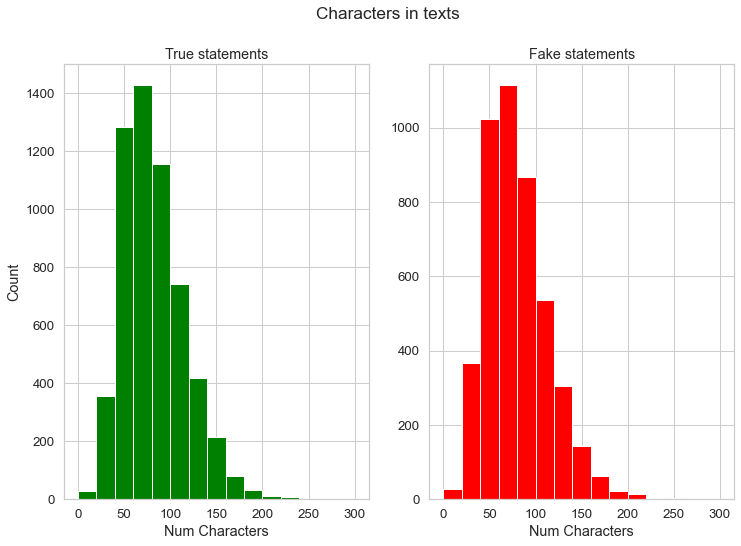

In [161]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))

text_len=train_df[train_df['binary_label']==True]['statement'].str.len()
ax1.hist(text_len,color='green',bins=15, range=(0,300))
ax1.set_title('True statements')
ax1.set_xlabel('Num Characters')
ax1.set_ylabel('Count')

text_len=train_df[train_df['binary_label']==False]['statement'].str.len()
ax2.hist(text_len,color='red',bins=15, range=(0,300))
ax2.set_title('Fake statements')
ax2.set_xlabel('Num Characters')

fig.suptitle('Characters in texts')
plt.show()

We can see that the distribution of number of characters is very similar

### Number of words in each text

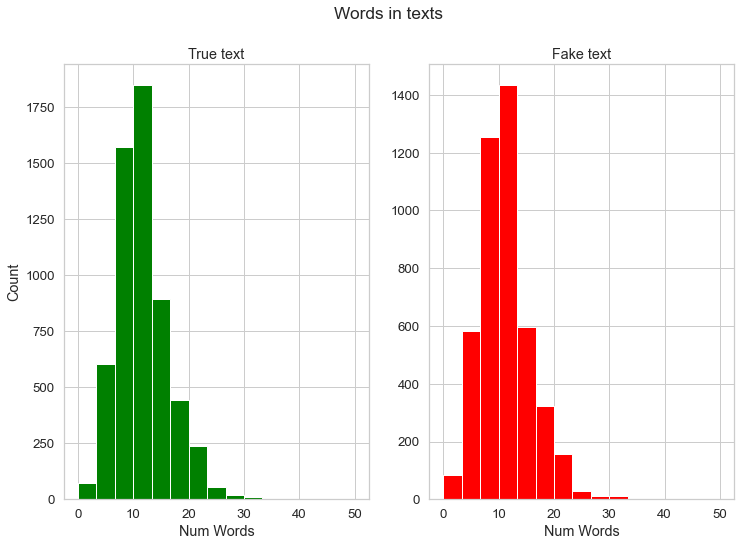

In [165]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))

text_len=train_df[train_df['binary_label']==True]['statement'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='green', bins=15, range=[0, 50])
ax1.set_title('True text')
ax1.set_xlabel('Num Words')
ax1.set_ylabel('Count')

text_len=train_df[train_df['binary_label']==False]['statement'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='red', bins=15, range=[0, 50])
ax2.set_title('Fake text')
ax2.set_xlabel('Num Words')


fig.suptitle('Words in texts')
plt.show()

Again we see a very similar distribution for the number of words in the True and False statements

### Average word length in a text

Text(0.5, 0.98, 'Average word length in each text')

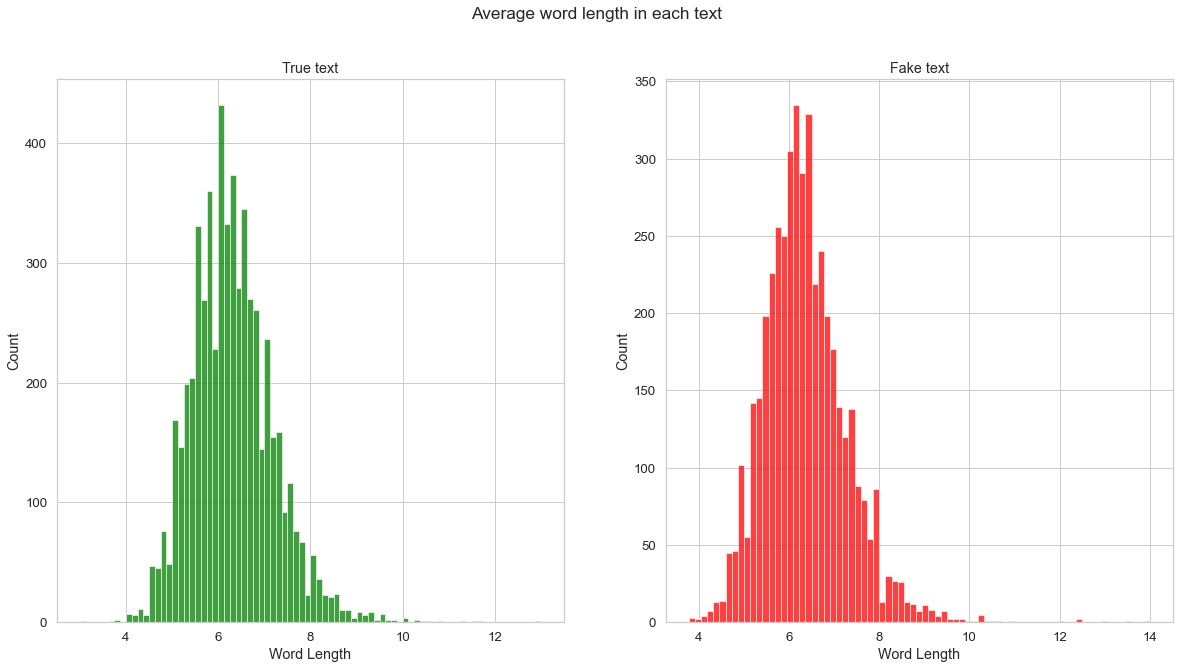

In [166]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))

word=train_df[train_df['binary_label']==True]['statement'].str.split().apply(lambda x : [len(i) for i in x]) # this is a pandas series
sns.histplot(word.map(lambda x: np.mean(x)), ax=ax1, color='green')
ax1.set_title('True text')
ax1.set_xlabel('Word Length')


word=train_df[train_df['binary_label']==False]['statement'].str.split().apply(lambda x : [len(i) for i in x])
sns.histplot(word.map(lambda x: np.mean(x)), ax=ax2, color='red')
ax2.set_title('Fake text')
ax2.set_xlabel('Word Length')


fig.suptitle('Average word length in each text')

## Sentiment Analysis

- In order to understand the emotional content and tone of a statement (which should be indicative of its truthfulness), we can apply sentiment analysis.
- Utilizing Vader sentiment analysis which is optimized for social media text: http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf
- While the nature of our data isn’t quite social media in the traditional Twitter/Facebook snippet sense, VADER is nice because it provides a real-valued composite sentiment score as well as separate positivity/negativity scores that we can plot.

In [167]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [168]:
analyzer = SentimentIntensityAnalyzer()

In [169]:
def extract_compound_sentiment(statement: str) -> float:
    return analyzer.polarity_scores(statement)["compound"]

def extract_pos_sentiment(statement: str) -> float:
    return analyzer.polarity_scores(statement)["pos"]

def extract_neg_sentiment(statement: str) -> float:
    return analyzer.polarity_scores(statement)["neg"]

def extract_neu_sentiment(statement: str) -> float:
    return analyzer.polarity_scores(statement)["neu"]

In [171]:
# takes a few minutes to execute
true_compound = true_ex.statement.apply(lambda x: extract_compound_sentiment(x))

In [172]:
px.histogram(true_compound, x=true_compound.values, labels={"x": "polarity"}, title="Compound Polarity of True Texts")

In [173]:
true_compound.describe()

count    5752.000000
mean       -0.014484
std         0.393846
min        -0.974400
25%        -0.280775
50%         0.000000
75%         0.273200
max         0.952400
Name: statement, dtype: float64

In [175]:
# takes a few minutes to execute
true_pos = true_ex.statement.apply(lambda x: extract_pos_sentiment(x))

In [176]:
true_pos.describe()

count    5752.000000
mean        0.096842
std         0.135075
min         0.000000
25%         0.000000
50%         0.000000
75%         0.187250
max         0.757000
Name: statement, dtype: float64

In [177]:
true_neg = true_ex.statement.apply(lambda x: extract_neg_sentiment(x))

In [178]:
true_neg.describe()

count    5752.000000
mean        0.105364
std         0.154228
min         0.000000
25%         0.000000
50%         0.000000
75%         0.200000
max         1.000000
Name: statement, dtype: float64

In [179]:
# takes a few minutes to execute
false_compound = false_ex.statement.apply(lambda x: extract_compound_sentiment(x))

In [180]:
px.histogram(false_compound, x=false_compound.values, labels={"x": "polarity"}, title="Compound Polarity of False Texts")

In [181]:
false_compound.describe()

count    4487.000000
mean        0.004728
std         0.382664
min        -0.973500
25%        -0.241100
50%         0.000000
75%         0.296000
max         0.937100
Name: statement, dtype: float64

In [182]:
false_pos = false_ex.statement.apply(lambda x: extract_pos_sentiment(x))

In [183]:
false_neg = false_ex.statement.apply(lambda x: extract_neg_sentiment(x))

In [184]:
false_pos.describe()

count    4487.000000
mean        0.104885
std         0.141730
min         0.000000
25%         0.000000
50%         0.000000
75%         0.197000
max         0.861000
Name: statement, dtype: float64

In [185]:
false_neg.describe()

count    4487.000000
mean        0.100496
std         0.151248
min         0.000000
25%         0.000000
50%         0.000000
75%         0.191000
max         1.000000
Name: statement, dtype: float64

According to VADER there are some sentiment differences between True and False statements, but not as much as one might expect. Our dataset does not tend to include many emotionally charged phrases. It still might be worth exploring usage of sentiment scores as features in our models. 

# Topic Modeling

- Topic modelling is a unsupervised technique to condense a set of documents in a corpus into a semantically meaningful collection of “topics.” By finding these abstract topics (which are often just a set of words that are computed according to certain algorithms), we can derive information about how the data in our collection is organized, the most meaningful terms, and other useful tidbits
- Will use latent semantic analysis (LSA), which performs a singular-value decomposition (SVD) on a document-term frequency matrix (with matrix elements being TF-IDF scores). LSA attempts to leverage the context around the words to capture the hidden concepts, known as topics. Using the components from the decomposition, we can find the words that are most representative of a topic.
- LSA does have some drawbacks, however. First and foremost, it is difficult to interpret. It treats human language as a bag of words, which of course has its limitations. And lastly, it is unable to capture polysemy (the coexistence of many possible meanings for a word or phrase).

In [189]:
# First generate the Document-Term Matrix using sklearn's TfidfVectorizer
# Then use sklearn’s TruncatedSVD to perform the task of matrix decomposition

# Let's wrap the procedure in a function for reusability
def lsa(df: pd.DataFrame, num_topics: int=5, num_words: int=5) -> None:
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', use_idf=True, smooth_idf=True)
    lsa_model = TruncatedSVD(n_components=num_topics)
    tfidf_transformed = tfidf_vectorizer.fit_transform(df.statement)
    lsa_transform = lsa_model.fit_transform(tfidf_transformed)
    return lsa_model, tfidf_vectorizer

In [187]:
def print_topics(model: TruncatedSVD, vectorizer: TfidfVectorizer, top_n: int=10) -> None:
    for idx, topic in enumerate(model.components_):
        print("Topic %d: " % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]])
        print("\n")

In [193]:
# LSA for True statements
model, vectorizer = lsa(true_ex, num_topics=10, num_words=8)
print_topics(model, vectorizer)

Topic 0: 
[('percent', 0.344493589593151), ('says', 0.30177997924796657), ('tax', 0.17718076382070347), ('state', 0.1757032442460366), ('000', 0.17566565359869035), ('years', 0.16236679398284057), ('year', 0.16055076518537253), ('health', 0.15560791358649328), ('obama', 0.1515938284279998), ('jobs', 0.1514727801400422)]


Topic 1: 
[('percent', 0.7111436127662278), ('rate', 0.13073654525672562), ('income', 0.11399251110560694), ('unemployment', 0.08217383847484816), ('40', 0.07833972543456917), ('highest', 0.0652791382619592), ('10', 0.05614470451499184), ('90', 0.05534511083647748), ('states', 0.0540988106989588), ('pay', 0.048204846682829004)]


Topic 2: 
[('health', 0.6083760822183218), ('care', 0.5080074311870919), ('insurance', 0.21145016348176046), ('percent', 0.19733847972930757), ('americans', 0.10378458082005496), ('plan', 0.09151913377119726), ('reform', 0.07411033906756048), ('law', 0.06593833718895312), ('coverage', 0.06565440455194901), ('people', 0.05611889547706205)]


T

In [194]:
# LSA for False statements
model, vectorizer = lsa(false_ex, num_topics=10, num_words=8)
print_topics(model, vectorizer)

Topic 0: 
[('says', 0.3715370030226774), ('health', 0.25971775466691244), ('obama', 0.24570549348048482), ('care', 0.2394902097603981), ('president', 0.2050806070938832), ('barack', 0.1823066389657928), ('tax', 0.18127488096219008), ('percent', 0.1812509828398531), ('state', 0.15296432332130774), ('000', 0.13423255824145822)]


Topic 1: 
[('health', 0.5334336440603055), ('care', 0.507307968296359), ('law', 0.15842129719700762), ('insurance', 0.11841264581935218), ('government', 0.09726583901085019), ('reform', 0.0757274569485763), ('plan', 0.0547562561486276), ('affordable', 0.05242881437184381), ('takeover', 0.04969101430767954), ('federal', 0.04946978140951739)]


Topic 2: 
[('obama', 0.4289226440250278), ('barack', 0.3623771295370457), ('president', 0.3522047239571188), ('health', 0.2569843266429965), ('care', 0.24443650926676594), ('obamas', 0.07191464236218484), ('law', 0.06393465210425846), ('muslim', 0.047570088852742054), ('government', 0.04078667937293592), ('insurance', 0.038

In True statements, looks like we have a strong topic on healthcare. But healthcare is also a topic in the False statements. Both also have topics on jobs and taxes. We can provide features to our model using topic-specific lexicons (vocabulary). In otherwords, the model can look to see if the statement includes healthcare or tax-related terms etc.

We can now take this exploratory data analysis and data cleaning, and create a few stand-alone scripts that do this cleaning and preprocessing automatically.